In [1]:
import pandas as pd
import numpy as np
import tqdm
import glob
import matplotlib.pyplot as plt

In [2]:
from google.colab import drive
drive.mount('/content/drive', force_remount = True)

Mounted at /content/drive


In [3]:
fileName = glob.glob("/content/drive/MyDrive/Stock/CNNpred/Processed_NYSE.csv")[0]
df = pd.read_csv(fileName, lineterminator='\n')
df

,Date,Close,Volume,mom,mom1,mom2,mom3,ROC_5,ROC_10,ROC_15,ROC_20,EMA_10,EMA_20,EMA_50,EMA_200,DTB4WK,DTB3,DTB6,DGS5,DGS10,Oil,Gold,DAAA,DBAA,GBP,JPY,CAD,CNY,AAPL,AMZN,GE,JNJ,JPM,MSFT,WFC,XOM,FCHI,FTSE,GDAXI,DJI,...,RUT,TE1,TE2,TE3,TE5,TE6,DE1,DE2,DE4,DE5,DE6,CTB3M,CTB6M,CTB1Y,Name,AUD,Brent,CAC-F,copper-F,WIT-oil,DAX-F,DJI-F,EUR,FTSE-F,gold-F,HSI-F,KOSPI-F,NASDAQ-F,GAS-F,Nikkei-F,NZD,silver-F,RUSSELL-F,S&P-F,CHF,Dollar index-F,Dollar index,wheat-F,XAG,XAU
0,2009-12-31,7184.959961,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.04,0.06,0.20,2.69,3.85,NaN,NaN,5.33,6.39,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,3.81,3.79,3.65,0.02,0.16,1.06,2.54,6.19,6.33,6.35,NaN,NaN,NaN,NYA,0.35,-0.13,0.15,0.09,0.10,0.48,-1.19,-0.12,0.27,0.34,1.68,-0.07,-0.96,-2.40,0.67,0.03,0.26,-1.08,-1.00,-0.11,-0.08,-0.06,-0.48,0.30,0.39
1,2010-01-04,7326.740234,0.921723,0.019733,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.05,0.08,0.18,2.65,3.85,0.026830,0.000000,5.35,6.39,-0.004222,-0.004467,-0.010644,-0.001991,0.015565,-0.004609,0.021150,0.004192,0.028318,0.015420,0.012227,0.014078,0.019724,NaN,NaN,0.014951,...,0.023521,3.80,3.77,3.67,0.03,0.13,1.04,2.54,6.21,6.31,6.34,-0.100000,-0.043860,-0.014870,NYA,1.73,2.81,1.99,1.36,2.71,0.96,1.28,0.61,1.74,2.05,-0.52,0.54,1.51,5.60,0.31,1.52,3.26,1.61,1.62,-0.57,-0.59,-0.42,3.12,3.91,2.10
2,2010-01-05,7354.870117,-0.375903,0.003839,0.019733,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.03,0.07,0.17,2.56,3.77,0.002699,0.001560,5.24,6.30,-0.007628,-0.009838,-0.001441,0.000015,0.001729,0.005900,0.005178,-0.011596,0.019370,0.000323,0.027452,0.003904,-0.000264,0.004036,-0.002718,-0.001128,...,-0.002515,3.74,3.70,3.60,0.04,0.14,1.06,2.53,6.13,6.23,6.27,-0.055556,-0.073394,-0.033962,NYA,-0.08,0.59,-0.11,0.24,0.32,-0.14,-0.04,-0.31,0.38,0.04,2.03,-0.18,-0.08,-4.20,0.47,-0.07,1.96,-0.20,0.31,0.43,0.03,0.12,-0.90,1.42,-0.12
3,2010-01-06,7377.700195,0.996234,0.003104,0.003839,0.019733,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.03,0.06,0.15,2.60,3.85,0.016883,0.006009,5.30,6.34,0.002067,0.008418,-0.007311,0.000191,-0.015906,-0.018116,-0.005151,0.008134,0.005494,-0.006137,0.001425,0.008643,0.001186,0.001358,0.000410,0.000157,...,-0.000846,3.82,3.79,3.70,0.03,0.12,1.04,2.49,6.19,6.28,6.31,-0.117647,0.000000,0.015625,NYA,0.91,1.61,0.15,2.41,1.72,-0.01,0.01,0.31,0.16,1.59,0.79,0.78,-0.36,6.60,0.19,0.56,2.15,-0.02,0.07,-0.56,-0.24,-0.17,2.62,2.25,1.77
4,2010-01-07,7393.930176,0.059932,0.002200,0.003104,0.003839,0.019733,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.02,0.05,0.16,2.62,3.85,-0.006256,0.000221,5.31,6.33,-0.005609,0.011196,0.002035,-0.000073,-0.001849,-0.017013,0.051780,-0.007137,0.019809,-0.010400,0.036286,-0.003142,0.001775,-0.000597,-0.002481,0.003138,...,0.006301,3.83,3.80,3.69,0.03,0.14,1.02,2.48,6.17,6.28,6.31,0.066667,0.019802,0.007692,NYA,-0.41,-0.46,0.15,-1.90,-0.63,-0.12,0.28,-0.66,0.06,-0.25,-0.60,-1.27,-0.05,-3.38,-0.09,-0.72,0.94,0.50,0.40,0.58,0.58,0.54,-1.85,0.22,-0.58
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1979,2017-11-09,12339.660156,-0.017375,-0.003638,0.001089,-0.002393,0.002252,-0.269134,-0.103377,-0.328426,0.007456,12365.601693,12347.558649,12233.432379,11781.391265,1.05,1.22,1.33,2.01,2.33,0.005984,0.000623,3.60,4.26,-0.004485,0.001459,-0.002633,-0.001988,-0.002043,-0.003310,-0.006461,-0.006864,-0.000102,-0.005558,-0.004792,0.005990,-0.011639,-0.006056,-0.014935,-0.004304,...,-0.004528,1.28,1.11,1.00,0.17,0.28,0.66,1.93,2.93,3.04,3.21,0.007407,-0.012121,0.000000,NYA,0.01,0.69,-1.17,-0.42,0.63,-1.42,-0.32,0.41,-0.41,0.30,0.61,-0.47,-0.43,0.79,-0.17,-0.24,-0.62,-0.34,-0.27,-0.61,-0.44,-0.45,0.53,-0.26,0.32
1980,2017-11-10,12322.599609,-0.089962,-0.001383,-0.003638,0.001089,-0.002393,-0.407821,-0.3544

In [4]:
import datetime

def make_datetime(date_str):
  return datetime.datetime.strptime(date_str, "%Y-%m-%d")

df['Date'] = df['Date'].apply(make_datetime)

Text(0.5, 1.0, 'Closing Price History')

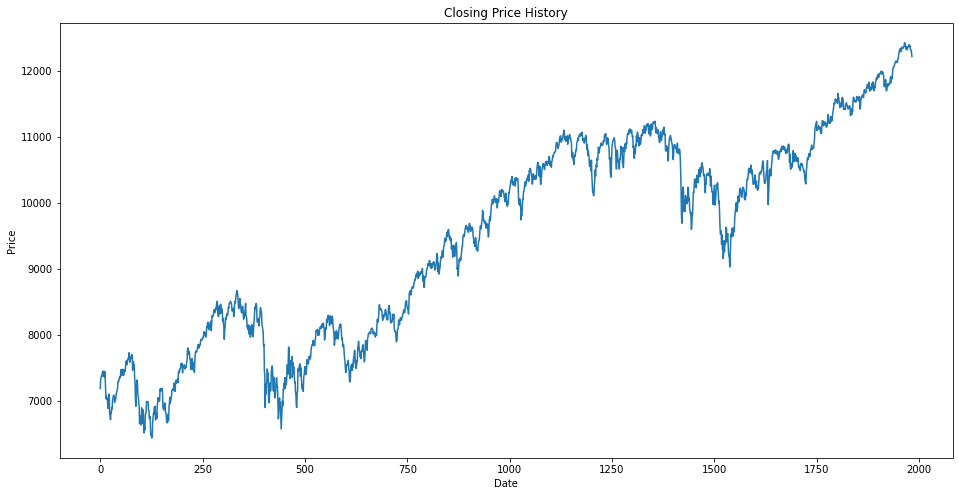

In [5]:
df = df.sort_values('Date')
plt.figure(figsize=(16,8))
plt.plot(df['Close'], label='Close Price')
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Closing Price History')

In [6]:
from statsmodels.tsa.stattools import adfuller

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [7]:
from pandas.plotting import autocorrelation_plot

In [8]:
from pandas.plotting import autocorrelation_plot

In [9]:
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
import statsmodels.api as sm

# Splitting Data

In [10]:
import math

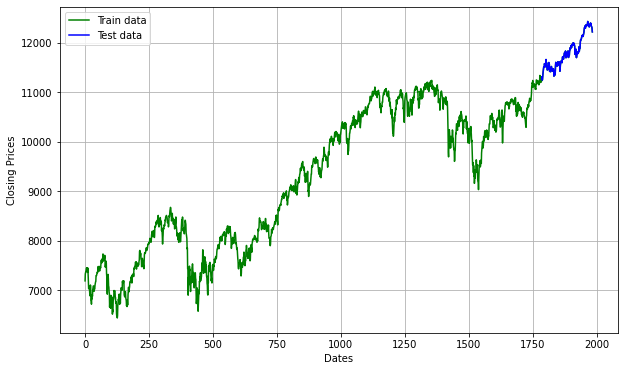

In [11]:
df_log = df['Close']
#split data into train and training set
train_data, test_data = df_log[3:int(len(df_log)*0.9)], df_log[int(len(df_log)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Closing Prices')
plt.plot(df_log, 'green', label='Train data')
plt.plot(test_data, 'blue', label='Test data')
plt.legend()

In [12]:
!pip3 install pmdarima
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
from pmdarima.arima import auto_arima

from sklearn.metrics import mean_squared_error, mean_absolute_error

     |████████████████████████████████| 1.4 MB 6.8 MB/s 
     |████████████████████████████████| 9.8 MB 32.1 MB/s 
  Attempting uninstall: statsmodels
    Found existing installation: statsmodels 0.10.2
    Uninstalling statsmodels-0.10.2:
      Successfully uninstalled statsmodels-0.10.2


                           Statespace Model Results                           
Dep. Variable:                      y   No. Observations:                 1782
Model:               SARIMAX(0, 1, 0)   Log Likelihood              -10480.877
Date:                Sat, 09 Oct 2021   AIC                          20963.754
Time:                        19:44:45   BIC                          20969.239
Sample:                             0   HQIC                         20965.780
                               - 1782                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      7564.4541    168.095     45.001      0.000    7234.994    7893.914
Ljung-Box (Q):                       70.39   Jarque-Bera (JB):               563.29
Prob(Q):                              0.00   Pr

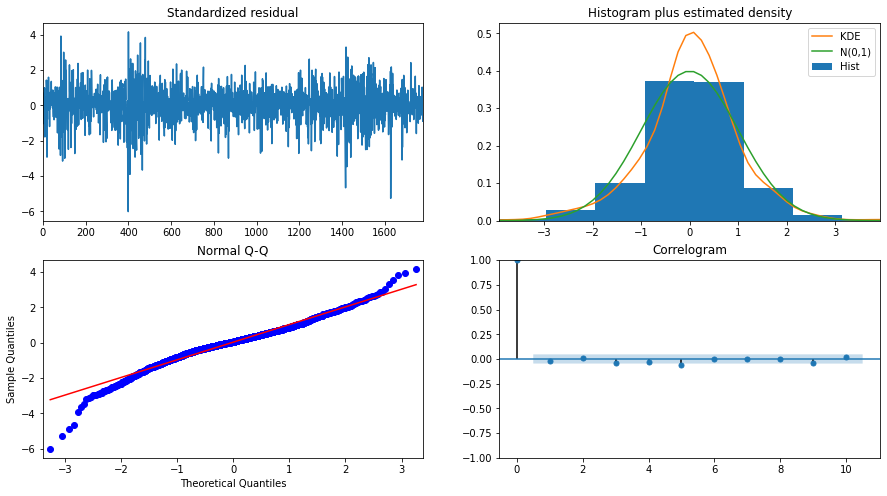

In [19]:
model_autoARIMA = auto_arima(train_data, start_p=0, start_q=0, test='adf', max_p=100, max_q=100, m=1, d=None, seasonal=False, start_P=0, D=0)
print(model_autoARIMA.summary())
model_autoARIMA.plot_diagnostics(figsize=(15,8))
plt.show()

Best model is with parameters (0, 1, 0)

In [14]:
model = ARIMA(train_data, order=(0,1,0))  
fitted = model.fit(disp=-1)
print(fitted.summary())

                             ARIMA Model Results                              
Dep. Variable:                D.Close   No. Observations:                 1781
Model:                 ARIMA(0, 1, 0)   Log Likelihood              -10480.330
Method:                           css   S.D. of innovations             86.972
Date:                Sat, 09 Oct 2021   AIC                          20964.661
Time:                        19:42:40   BIC                          20975.630
Sample:                             1   HQIC                         20968.712
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.1548      2.061      1.046      0.296      -1.884       6.194


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:215: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:215: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  


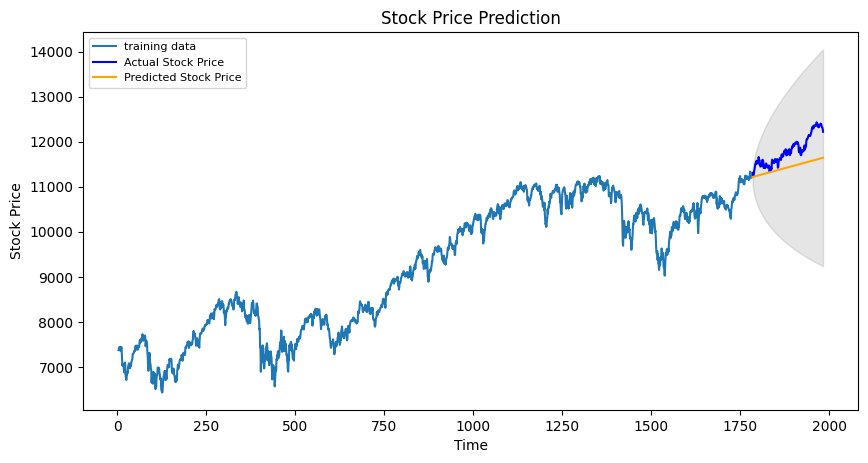

In [15]:
fc, se, conf = fitted.forecast(199, alpha=0.05)
fc_series = pd.Series(fc, index=test_data.index)
lower_series = pd.Series(conf[:, 0], index=test_data.index)
upper_series = pd.Series(conf[:, 1], index=test_data.index)

plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label='training data')
plt.plot(test_data, color = 'blue', label='Actual Stock Price')
plt.plot(fc_series, color = 'orange',label='Predicted Stock Price')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.10)
plt.title('Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend(loc='upper left', fontsize=8)
plt.show()

In [21]:
mse = mean_squared_error(test_data, fc)
mae = mean_absolute_error(test_data, fc)
rmse = math.sqrt(mean_squared_error(test_data, fc))
mape = np.mean(np.abs(fc - test_data)/np.abs(test_data))
print('MSE: ', str(mse))
print('MAE: ', str(mae))
print('RMSE: ', str(rmse))
print('MAPE: ', str(mape))

MSE:  179135.6783816298
MAE:  369.0577405187173
RMSE:  423.2442301811447
MAPE:  0.030844212131216738


In [17]:
training_data = train_data.values
test_data = test_data.values
history = [x for x in training_data]
model_predictions = []
N_test_observations = len(test_data)
for time_point in range(N_test_observations):
    model = ARIMA(history, order=(0,1,0))
    model_fit = model.fit(disp=0)
    output = model_fit.forecast()
    yhat = output[0]
    model_predictions.append(yhat)
    true_test_value = test_data[time_point]
    history.append(true_test_value)
MSE_error = mean_squared_error(test_data, model_predictions)
print('Testing Mean Squared Error is {}'.format(MSE_error))

Testing Mean Squared Error is 2472.3762738219816


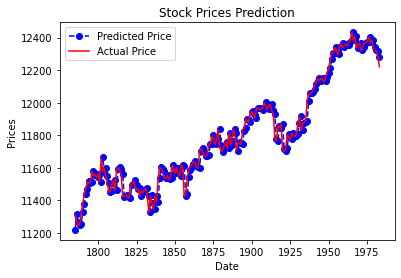

In [24]:
range_s = df[int(len(df)*0.9):].index
plt.plot(range_s, model_predictions, color='blue', marker='o', linestyle='dashed',label='Predicted Price')
plt.plot(range_s, test_data, color='red', label='Actual Price')
plt.title('Stock Prices Prediction')
plt.xlabel('Date')
plt.ylabel('Prices')
plt.legend()
plt.show()